In [95]:
import pickle
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from analyticalSolver import generateQUBO, isInputValid, decodeBitstring

matplotlib.rc('text', usetex=False)
matplotlib.rc('font', family='serif')
BIG_TEXT = 12
MEDIUM_TEXT = 10
SMALL_TEXT = 8
plt.rcParams['figure.dpi'] = 150
plt.rcParams['axes.axisbelow'] = True

# textwidth = 7.14 in
# columnwidth = 3.49 in

# Plot 1

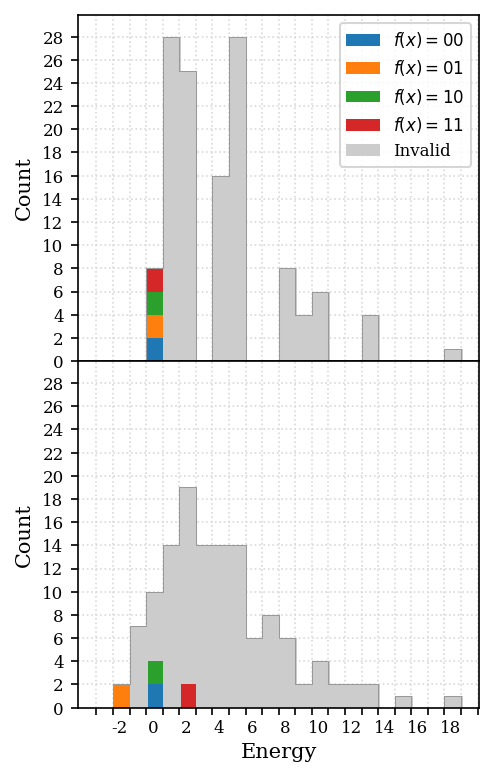

In [122]:
# Set constant variables.
N = 3
PENALTIES = [None, [2, -2]]

fig, ax = plt.subplots(2, 1, figsize=(3.45, 6.0), sharex=True)
fig.subplots_adjust(hspace=0)

# For each penalty value:
for idx, penalty in enumerate(PENALTIES):

    # Generate the corresponding QUBO.
    Q = generateQUBO(N, penalty, True)

    # Get the number of qubits in the problem.
    num_qubits = len(Q)

    # Instantiate needed data structures.
    valid = dict()
    invalid = []

    # For each possible assignment of classical values to the qubits:
    for i in range(2**num_qubits):

        # Compute the expectation of that bitstring with the QUBO.
        x = np.array(list(map(int, list(format(i, f'0{num_qubits}b')))))
        expectation = x.T @ Q @ x

        # Decode the bitstring and check if it is valid.
        inputs, outputs, ancillas = decodeBitstring(x)
        isValid = isInputValid(inputs, outputs, ancillas)

        # Record the bitstring and its expectation in the proper structures.
        if isValid:
            key = ''.join(map(str, outputs))
            if key in valid:
                valid[key].append(expectation)
            else:
                valid[key] = [expectation]
        else:
            invalid.append(expectation)
        decodedString = str(
            ''.join(map(str, inputs)) + ' ' +
            ''.join(map(str, outputs)) + ' ' +
            ''.join(map(str, ancillas))
        )


    # plt.figure(figsize=(10,10))

    # Plot the results in a histogram.
    categories = [valid[result] for result in valid]
    categories.append(invalid)
    ax[idx].hist(
        categories,
        bins=np.arange(-3, 20),
        color=['C0', 'C1', 'C2', 'C3', '0.8'],
        histtype='barstacked',
        label=['$f(x) = 00$', '$f(x) = 01$', '$f(x) = 10$', '$f(x) = 11$', 'Invalid'],
        width=1.1
    )
    ax[idx].hist(
        [x for xs in categories for x in xs],
        bins=np.arange(-3, 20),
        color=['0.6'],
        histtype='step',
        linewidth=0.5
    )

    ax[idx].tick_params(which='major', labelsize=SMALL_TEXT)

    # Label the plot.
    ax[idx].set_yticks(range(0, 30, 2))
    ax[idx].set_ylim(0, 29.9)
    ax[idx].set_ylabel(f'Count', fontsize=MEDIUM_TEXT)

    # Set ticks on every integer
    ticks = list(range(-3, 21, 1))
    ax[idx].set_xticks(ticks)

    # Set labels only for even integers
    labels = [str(int(tick)) if int(tick) % 2 == 0 and tick != 20 else '' for tick in ticks]

    # Clear existing tick labels
    ax[idx].set_xticklabels([])
    ax[idx].grid(which='major', color='0.85', linestyle=':')

    # Manually place the labels at the desired x positions
    for tick, label in zip(ticks, labels):
        if label:  # Only place labels for even integers
            ax[idx].text(tick + 0.4, -1, label, ha='center', va='top', fontsize=SMALL_TEXT)

    

    ax[0].legend(fontsize=SMALL_TEXT, frameon=True, loc='upper right')
    ax[1].set_xlabel('Energy', labelpad=10, fontsize=MEDIUM_TEXT)

# ax[0].annotate("asdf", (5, 5), xytext=(10, 10), fontsize=SMALL_TEXT, arrowprops={'width':0.0, 'headwidth':2, 'headlength':1})

# Save the plot.
# fig.tight_layout()
plt.savefig('../pdfFigs/energySpectrum.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Plot 2

In [3]:
def Mixture(x, a, b):
    return np.maximum(np.exp(a*x**2), np.exp(b*x))

def Unmixture1(x, a, b):
    return np.exp(a*x**2)
def Unmixture2(x, a, b):
    return np.exp(b*x)

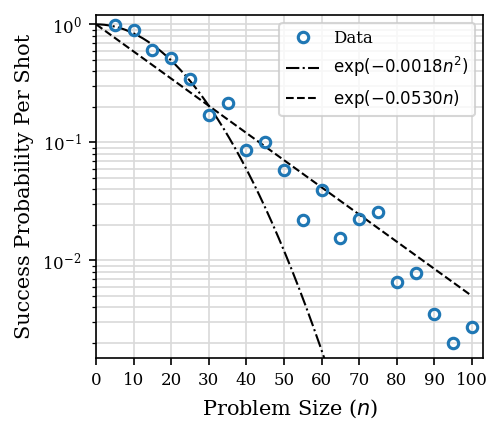

In [79]:
domain = np.linspace(0, 100, 1000)

with open('../figureData/plot3.pkl', 'rb') as file:
    data = pickle.load(file)
xVals = data['xVals']
yVals = data['yVals']

popt, pcov = curve_fit(Mixture, xVals, yVals, p0=[-.001, -0.062])

fig, ax = plt.subplots(figsize=(3.45, 3.0))

# ax.semilogy(xVals, yVals, 'o', color='C0', ms=5, mew=1.5, alpha=0.25, zorder=10)
ax.semilogy(xVals, yVals, 'o', color='C0', mfc='None', ms=5, mew=1.5, label='Data', zorder=10)

# ax.semilogy(DOMAIN, Mixture(DOMAIN, *popt), linewidth=1, color='C0', linestyle='--')
ax.semilogy(domain, Unmixture1(domain, *popt), linewidth=1, color='k', linestyle='-.', label=f'$\\exp({popt[0]:.4f}n^2)$')
ax.semilogy(domain, Unmixture2(domain, *popt), linewidth=1, color='k', linestyle='--', label=f'$\\exp({popt[1]:.4f}n)$')


ax.set_xlabel('Problem Size ($n$)', fontsize=MEDIUM_TEXT)
ax.set_ylabel('Success Probability Per Shot', fontsize=MEDIUM_TEXT)
ax.tick_params(which='major', labelsize=SMALL_TEXT)
ax.grid(which='major', color='0.85')
ax.grid(which='minor', color='0.85')
ax.set_xticks(np.arange(0, 101, 10))
ax.set_ylim(1.5e-3, 1.2)
ax.set_xlim(0, 103)

ax.legend(fontsize=SMALL_TEXT, frameon=True, loc='upper right')
fig.tight_layout()
plt.savefig('../pdfFigs/successRate.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Plot 3

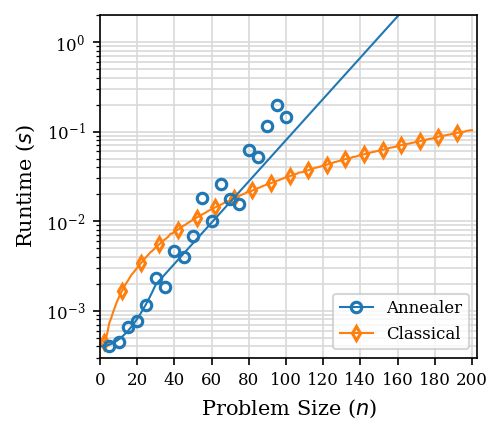

In [78]:
classical = [np.float64(0.00044956207275390623), np.float64(0.0004747629165649414), np.float64(0.0005671977996826172), np.float64(0.0007255315780639648), np.float64(0.000821995735168457), np.float64(0.0009534120559692383), np.float64(0.0010893583297729493), np.float64(0.0012411355972290039), np.float64(0.001380157470703125), np.float64(0.0015497446060180665), np.float64(0.0016789913177490234), np.float64(0.0018474817276000976), np.float64(0.0020120859146118162), np.float64(0.0021586894989013674), np.float64(0.002342367172241211), np.float64(0.0025244712829589843), np.float64(0.0026704549789428713), np.float64(0.0028414249420166014), np.float64(0.003013348579406738), np.float64(0.0032061338424682617), np.float64(0.0033914327621459963), np.float64(0.003581523895263672), np.float64(0.0038069486618041992), np.float64(0.004010319709777832), np.float64(0.004210662841796875), np.float64(0.004471278190612793), np.float64(0.004634642601013183), np.float64(0.004855680465698242), np.float64(0.005129051208496094), np.float64(0.005320405960083008), np.float64(0.005548167228698731), np.float64(0.0057628870010375975), np.float64(0.006069850921630859), np.float64(0.006259369850158692), np.float64(0.0065097808837890625), np.float64(0.006808161735534668), np.float64(0.007269454002380371), np.float64(0.007287502288818359), np.float64(0.007653236389160156), np.float64(0.007787680625915528), np.float64(0.008063888549804688), np.float64(0.008324575424194337), np.float64(0.008645939826965331), np.float64(0.008907914161682129), np.float64(0.009145092964172364), np.float64(0.009487175941467285), np.float64(0.009743762016296387), np.float64(0.010069561004638673), np.float64(0.010384273529052735), np.float64(0.010648822784423828), np.float64(0.010944676399230958), np.float64(0.011266422271728516), np.float64(0.011558461189270019), np.float64(0.011887001991271972), np.float64(0.012220430374145507), np.float64(0.012517333030700684), np.float64(0.012926697731018066), np.float64(0.013268637657165527), np.float64(0.013614249229431153), np.float64(0.013966894149780274), np.float64(0.014245891571044922), np.float64(0.014617991447448731), np.float64(0.014892506599426269), np.float64(0.015282177925109863), np.float64(0.015628767013549805), np.float64(0.016181039810180663), np.float64(0.01644287109375), np.float64(0.01684901714324951), np.float64(0.01721663475036621), np.float64(0.01758880615234375), np.float64(0.017967867851257324), np.float64(0.018524956703186036), np.float64(0.018806195259094237), np.float64(0.01924765110015869), np.float64(0.019623613357543944), np.float64(0.019988465309143066), np.float64(0.0203840970993042), np.float64(0.02112898826599121), np.float64(0.021155381202697755), np.float64(0.02159457206726074), np.float64(0.022060608863830565), np.float64(0.022489070892333984), np.float64(0.022901487350463868), np.float64(0.0233717679977417), np.float64(0.02380187511444092), np.float64(0.024380946159362794), np.float64(0.02482132911682129), np.float64(0.025292420387268068), np.float64(0.02594137191772461), np.float64(0.026231789588928224), np.float64(0.026624178886413573), np.float64(0.02706913948059082), np.float64(0.02755582332611084), np.float64(0.028198432922363282), np.float64(0.028599023818969727), np.float64(0.029173779487609863), np.float64(0.029590535163879394), np.float64(0.030314064025878905), np.float64(0.030795478820800783), np.float64(0.031215977668762208), np.float64(0.0317913293838501), np.float64(0.032279682159423825), np.float64(0.03309798240661621), np.float64(0.03345558643341064), np.float64(0.03389499187469482), np.float64(0.03489551544189453), np.float64(0.035057568550109865), np.float64(0.03532352447509766), np.float64(0.0358924388885498), np.float64(0.03646421432495117), np.float64(0.03714408874511719), np.float64(0.03763625621795654), np.float64(0.03813176155090332), np.float64(0.03879690170288086), np.float64(0.03954634666442871), np.float64(0.03990187644958496), np.float64(0.040489721298217776), np.float64(0.041086459159851076), np.float64(0.0417417049407959), np.float64(0.042303276062011716), np.float64(0.04282047748565674), np.float64(0.043330836296081546), np.float64(0.04400248527526855), np.float64(0.044608569145202635), np.float64(0.04561624526977539), np.float64(0.045931029319763186), np.float64(0.046676135063171385), np.float64(0.04713270664215088), np.float64(0.04776985645294189), np.float64(0.04869234561920166), np.float64(0.04922177791595459), np.float64(0.04989347457885742), np.float64(0.05031518936157227), np.float64(0.051011300086975096), np.float64(0.052025246620178225), np.float64(0.052366209030151364), np.float64(0.05291481018066406), np.float64(0.05386371612548828), np.float64(0.05438442230224609), np.float64(0.05539040565490723), np.float64(0.05574676990509033), np.float64(0.05652663707733154), np.float64(0.05735988616943359), np.float64(0.05789663791656494), np.float64(0.058601880073547365), np.float64(0.05919473171234131), np.float64(0.059947538375854495), np.float64(0.06072518825531006), np.float64(0.06122000217437744), np.float64(0.06252350807189941), np.float64(0.06265432834625244), np.float64(0.06324622631072999), np.float64(0.06392192840576172), np.float64(0.06503674983978272), np.float64(0.06587038040161133), np.float64(0.06646504402160644), np.float64(0.06695513725280762), np.float64(0.067755126953125), np.float64(0.06865379810333253), np.float64(0.06960859298706054), np.float64(0.07065837383270264), np.float64(0.07114303112030029), np.float64(0.07183892726898193), np.float64(0.0727163553237915), np.float64(0.07327437400817871), np.float64(0.0741530179977417), np.float64(0.07497022151947022), np.float64(0.07565646171569824), np.float64(0.07646193504333496), np.float64(0.07730779647827149), np.float64(0.07800071239471436), np.float64(0.07917308807373047), np.float64(0.07996933460235596), np.float64(0.08072714805603028), np.float64(0.08160746097564697), np.float64(0.08296780586242676), np.float64(0.08326451778411866), np.float64(0.0841282844543457), np.float64(0.08492929935455322), np.float64(0.0856553554534912), np.float64(0.08783001899719238), np.float64(0.0888897180557251), np.float64(0.08926465511322021), np.float64(0.0902977705001831), np.float64(0.09089164733886719), np.float64(0.09205420017242431), np.float64(0.09272944927215576), np.float64(0.09390127658843994), np.float64(0.09514150619506836), np.float64(0.09534580707550049), np.float64(0.09655053615570068), np.float64(0.09737250804901124), np.float64(0.09814765453338622), np.float64(0.09926235675811768), np.float64(0.09985086917877198), np.float64(0.10158030986785889), np.float64(0.10245223045349121), np.float64(0.10319788455963134), np.float64(0.10343635082244873)]
domain = np.linspace(0, 200, 1000)

fig, ax = plt.subplots(figsize=(3.45, 3.0))

ax.semilogy(np.arange(2, 201, 1), classical, linewidth=1, color='C1', linestyle='-')
# ax.semilogy(np.arange(2, 201, 1)[::10], classical[::10], 'd', color='C1', ms=5, mew=1.5, alpha=0.25)
ax.semilogy(np.arange(2, 201, 1)[::10], classical[::10], 'd', color='C1', mfc='None', ms=5, mew=1.5)
ax.semilogy(domain, 2/Mixture(domain, *popt)*(100e-6)*2, linewidth=1, color='C0', linestyle='-')
# ax.semilogy(xVals, 2/np.array(yVals)*(100e-6)*2, 'o', color='C0', ms=5, mew=1.5, alpha=0.25)
ax.semilogy(xVals, 2/np.array(yVals)*(100e-6)*2, 'o', color='C0', mfc='None', ms=5, mew=1.5)

ax.semilogy([-1], [-1], linewidth=1, color='C0', linestyle='-', marker='o', ms=5, mew=1.5, mfc='None', label='Annealer')
ax.semilogy([-1], [-1], linewidth=1, color='C1', linestyle='-', marker='d', ms=5, mew=1.5, mfc='None', label='Classical')

ax.set_xlabel('Problem Size ($n$)', fontsize=MEDIUM_TEXT)
ax.set_ylabel('Runtime ($s$)', fontsize=MEDIUM_TEXT)
ax.tick_params(which='major', labelsize=SMALL_TEXT)
ax.grid(which='major', color='0.85')
ax.grid(which='minor', color='0.85')
ax.set_xticks(np.arange(0, 201, 20))
ax.set_ylim(3e-4, 2)
ax.set_xlim(0, 203)

ax.legend(fontsize=SMALL_TEXT, frameon=True, loc='lower right')
fig.tight_layout()
plt.savefig('../pdfFigs/runtime.pdf', format='pdf', bbox_inches='tight')
plt.show()